In [22]:
from skimage import io, feature, filters
import os
import matplotlib.pyplot as plt
import numpy as np
import sep

In [39]:
%matplotlib inline

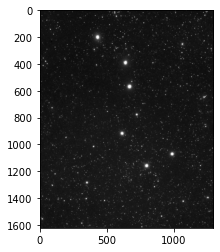

In [41]:
in_folder = 'assets'
in_file = 'big_dipper_blue_ch.tif'

source_image = io.imread(os.path.join(in_folder, in_file))
plt.imshow(source_image, cmap='gray')

In [28]:
source_image.shape

(1623, 1293)

In [46]:
blobs_log = feature.blob_log(source_image, min_sigma=20, max_sigma=30, num_sigma=10, threshold=.1)
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)
blobs_log.shape

(10, 3)

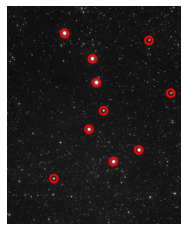

In [47]:
fig, ax = plt.subplots()
ax.imshow(source_image, cmap='gray')
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
ax.set_axis_off()